# Radially symmetric off-axis PSFs
The most basic format for off-axis PSFs provided by a yield input package is a radially symmetric one. 

In [3]:
from pathlib import Path

# Path to the yield input package directory
# yip_path = Path("../../input/LUVOIR-B-VC6_timeseries")
yip_path = Path("../../input/coronagraphs/usort")

In [4]:
# Loading the offax_psf files directly
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
from lod_unit import (
    lod,  # NOTE: `lod` is an astropy unit for lambda/D, I defined it enough that I made it a package
)

offax_psf_data = pyfits.getdata(Path(yip_path, "offax_psf.fits"))
offax_psf_offsets_list = pyfits.getdata(Path(yip_path, "offax_psf_offset_list.fits"))

## The offsets
Here we plot the $(x,y)$ offsets in $\lambda/D$ space. Because the coronagraph is treated as radially symmetric they are all along the x-axis (some packages will provide them along the y-axis, but we always translate those to be along the x-axis). 

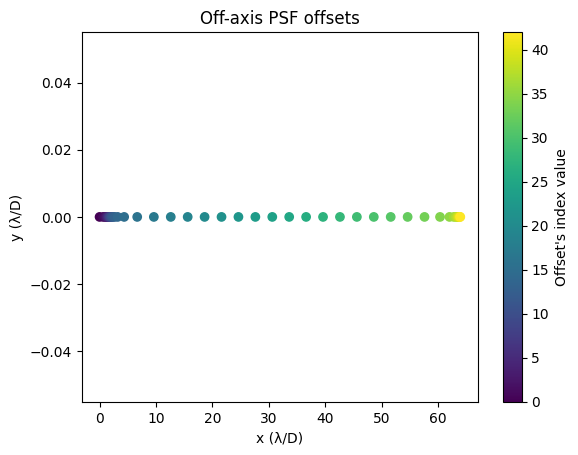

In [5]:
n_offsets = offax_psf_offsets_list.shape[0]
y_vals = np.zeros(n_offsets)
scatter = plt.scatter(offax_psf_offsets_list, y_vals, c=np.arange(n_offsets))
plt.title("Off-axis PSF offsets")
plt.xlabel(f"x ({lod})")
plt.ylabel(f"y ({lod})")
plt.colorbar(scatter, label="Offset's index value")
plt.show()

## The PSFs
Now, lets look at what the psfs included in the yield input package look like. Given that all the offsets are along the x-axis we would assume that the PSFs show a point source moving along the x-axis as well.

In [6]:
# Utility functions
def set_up_plot():
    rows, cols = 4, 4
    base_size = 3
    fig, axes = plt.subplots(
        nrows=rows, ncols=cols, figsize=(base_size * cols, base_size * rows)
    )
    return fig, axes


def ax_labels_and_ticks(ax):
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("y (pixel)")
    else:
        ax.set_yticks([])
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("x (pixel)")
    else:
        ax.set_xticks([])
    return ax

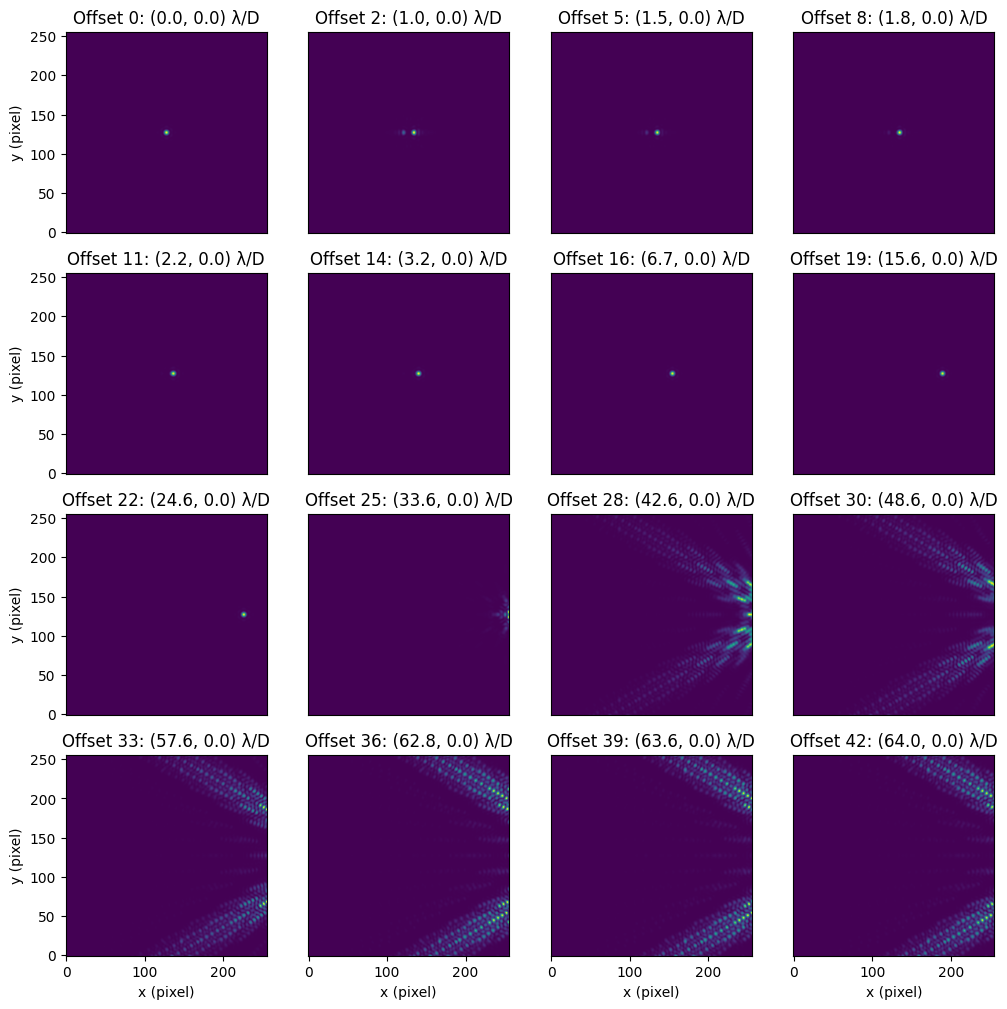

In [7]:
### Plotting PSF data
fig, axes = set_up_plot()

# Choosing the PSF offset index values
offsets = np.linspace(
    0, len(offax_psf_offsets_list.T) - 1, axes.shape[0] * axes.shape[1], dtype=int
)

# Loop through and plot the PSFs
for ax, offset in zip(axes.flatten(), offsets):
    # Get the x, y values of the offset from the offset list
    offset_x, offset_y = offax_psf_offsets_list[offset], 0

    # Load the PSF from the provided data
    psf = offax_psf_data[offset]

    # Plot the PSF data at the current offset
    ax.imshow(psf, origin="lower")

    # Make the plot pretty
    ax.set_title(f"Offset {offset}: ({offset_x:.1f}, {offset_y:.1f}) {lod}")
    ax = ax_labels_and_ticks(ax)
plt.show()

## Using yippy
I would assume you don't want to be limited to these specific PSFs that are all on the positive x-axis. Luckily, the major use-case for yippy is to handle all the interpolation and rotation for you!

In [10]:
# yippy has a lot of logging messages, disabling to keep this documentation clean
import logging

from yippy import Coronagraph

yippy_logger = logging.getLogger("yippy")
yippy_logger.setLevel(logging.ERROR)

In [11]:
coro = Coronagraph(yip_path)

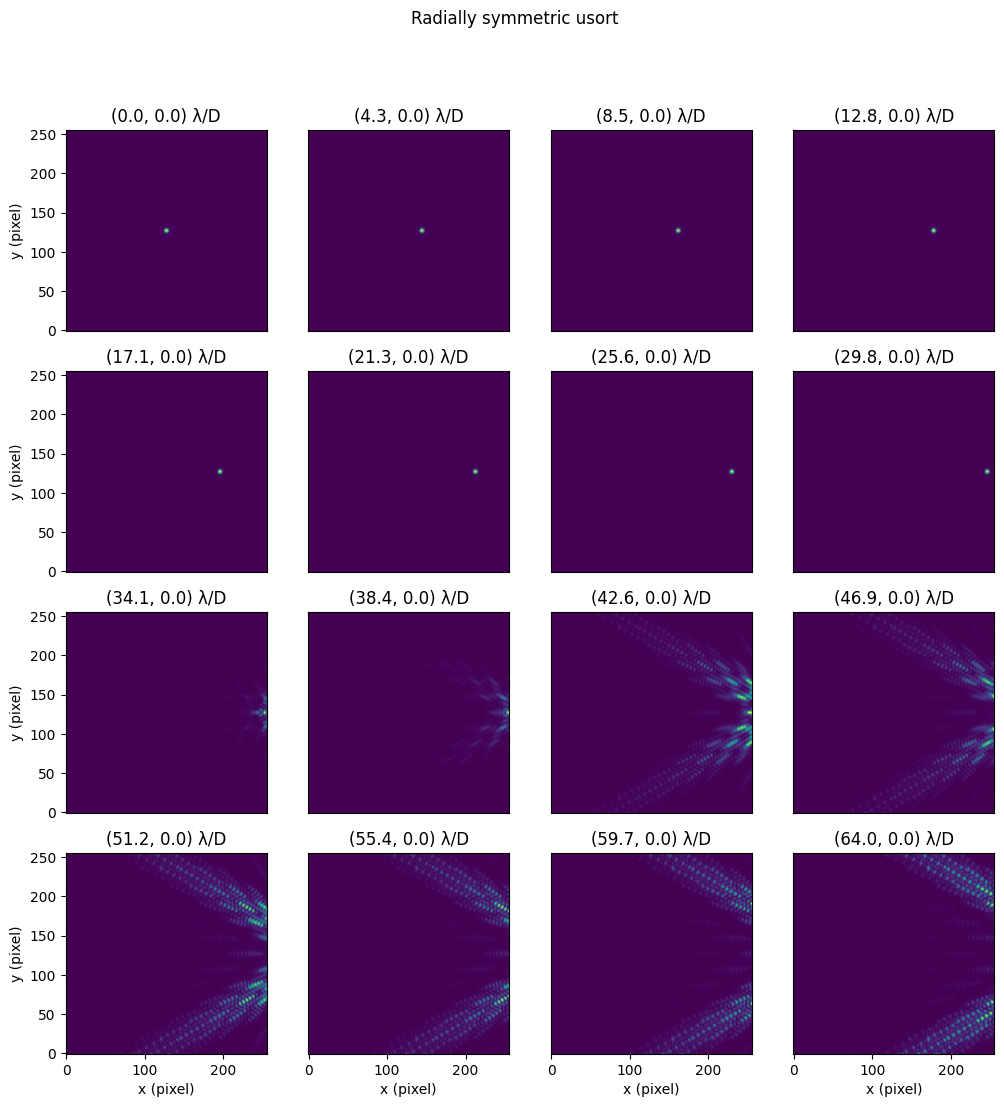

In [12]:
### Plotting PSF data
fig, axes = set_up_plot()

# Choosing the PSF offset index values
n_plots = axes.shape[0] * axes.shape[1]

x_offsets = np.linspace(0, max(offax_psf_offsets_list), n_plots) * lod
y_offsets = np.zeros(n_plots) * lod

# Loop through and plot the PSFs
for ax, x, y in zip(axes.flatten(), x_offsets, y_offsets):
    # USE YIPPY TO GENERATE THE PSF
    ######################
    psf = coro.offax(x, y)
    ######################

    # Plot the PSF data at the current offset
    ax.imshow(psf, origin="lower")

    # Make the plot pretty
    ax.set_title(f"({x.value:.1f}, {y.value:.1f}) {lod}")
    ax = ax_labels_and_ticks(ax)
fig.suptitle(f"Radially symmetric {coro.name}")
plt.show()

Ok, it isn't an exact match because the offsets in the YIP were not spaced linearly (nor do they have to be for sampling reasons) and I used `np.linspace`. However, `yippy` interpolated between the provided offsets PSFs which is what we want! I should note here that as with any interpolation, we are at the mercy of the data given to the interpolant. If the offsets are poorly sampled there is nothing that can be done to fill in the missing information.

## Interpolation in 2D
Lets make a quick plot of random 2D offsets in $\lambda/D$ units (with logarithmic normalization).

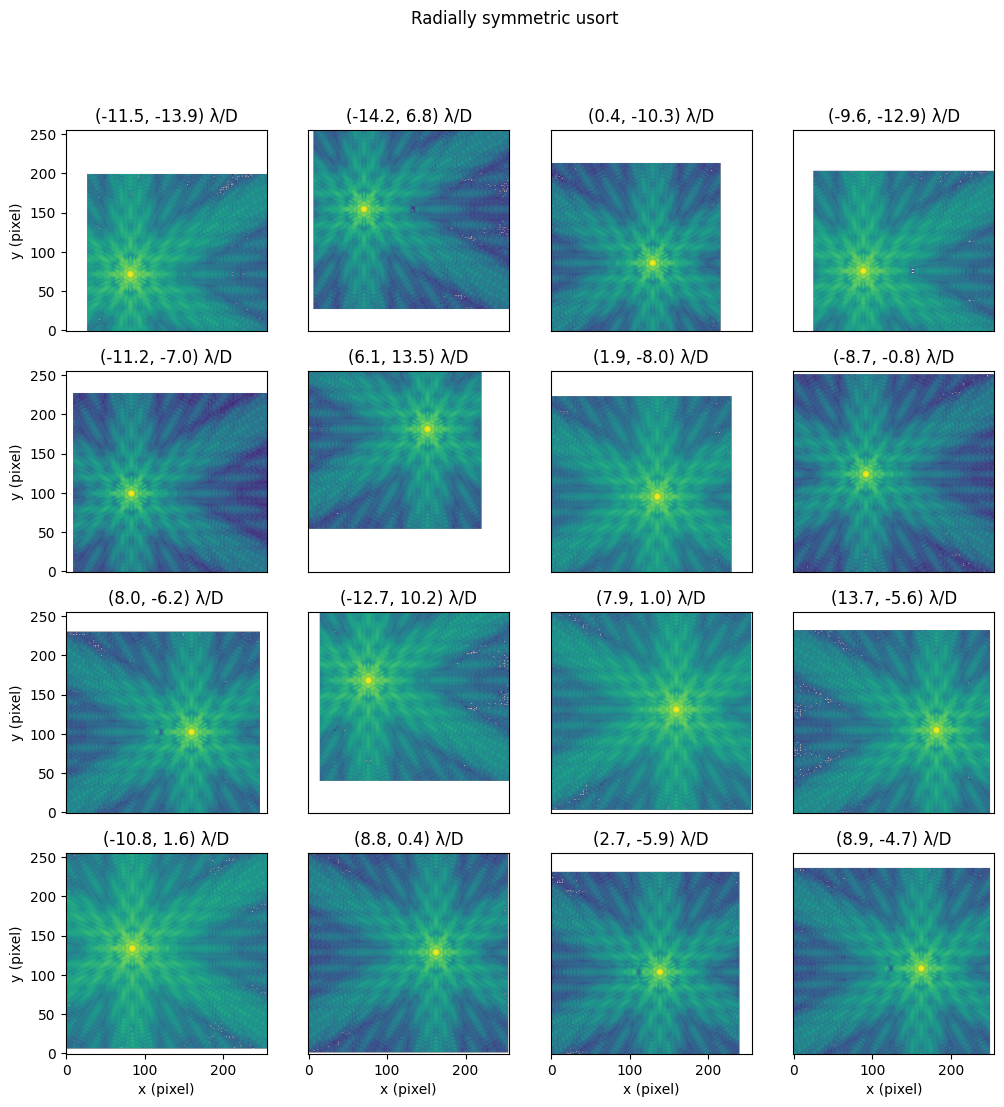

In [17]:
from matplotlib.colors import LogNorm
### Plotting PSF data
fig, axes = set_up_plot()

# Choosing the PSF offset index values
n_plots = axes.shape[0] * axes.shape[1]

x_offsets = np.random.uniform(low=-15, high=15, size=(n_plots,)) * lod
y_offsets = np.random.uniform(low=-15, high=15, size=(n_plots,)) * lod

# Loop through and plot the PSFs
for ax, x, y in zip(axes.flatten(), x_offsets, y_offsets):
    # USE YIPPY TO GENERATE THE PSF
    ######################
    psf = coro.offax(x, y)
    ######################

    # Plot the PSF data at the current offset
    ax.imshow(psf, origin="lower", norm=LogNorm())

    # Make the plot pretty
    ax.set_title(f"({x.value:.1f}, {y.value:.1f}) {lod}")
    ax = ax_labels_and_ticks(ax)
fig.suptitle(f"Radially symmetric {coro.name}")
plt.show()